# You Are What You Eat (Macro Regressor)

**Name(s)**: Advay Singh

**Website Link**: https://advaysingh1.github.io/Macro-Regressor/

In [31]:
import pandas as pd
import numpy as np

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

In [32]:
# other utils
def print_series(s):
    print(s.reset_index().to_string(index=False, header=False))

## Step 1: Introduction

#### Why Nutrition
Nutrition is something relevant to everyone.
Possible Questions

#### Regression Questions
1) What types of recipes tend to have higher average ratings?
2) What types of recipes tend to have the most calories?
3) What is the relationship between the cooking time and average rating of recipes?

#### Classification Questions
1) Classifying the kind of recipe based on the Nutrition information (dessert, lunch, etc.)?
2) What types of recipes tend to have the most calories?
3) What types of recipes tend to have higher average ratings?
4) What types of recipes tend to be healthier (i.e. more protein, fewer carbs)?
 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [33]:
# read in the datasets

raw_interactions_df = pd.read_csv('data/RAW_interactions.csv')
raw_recipies_df = pd.read_csv('data/RAW_recipes.csv')


# merging the dataframes
df = raw_recipies_df.merge(right=raw_interactions_df, how='left', left_on='id', right_on='recipe_id').drop(['recipe_id', 'review'], axis=1)

#df = df.iloc[:1000, :]
#print(pd.Series(df.columns).to_markdown(index=False))

### Data Cleaning and Imputation

In [34]:
# Transform the rating column
def transform_rating(df):
    df['rating'] = df['rating'].transform(lambda x: x if x != 0 else np.nan)
    df['rating'].fillna(df['rating'].mean(), inplace=True) # mean imputation
    return df

# Transform the nutrition column
def transform_nutrition(df):
    nutritional_parts = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
    # the percent daily values
    daily_values = [1000, 78, 50, 2300, 50, 20, 275]

    def _helper(s, index):
        return (float(s[2:-1].split(',')[index]) / 100) * daily_values[index]

    for i, part in enumerate(nutritional_parts):
        df[part] = df['nutrition'].transform(lambda s: _helper(s, i))
    return df


# Transform the ingredients column & tag
def transform_string_lists(df, col):
    def _helper(s):
        return np.unique([val.strip() for val in s[1:-1].replace("'", "").split(',')]) # np array for speed later on
    df[col] = df[col].transform(_helper)
    return df
    
def transform_calories(df):
    df['calories'] = df['fat'] * 9 + df['protein'] * 4 + df['carbohydrates'] * 4
    return df


(df
    .pipe(transform_rating)
    .pipe(transform_nutrition)
    .pipe(transform_string_lists, 'ingredients')
    .pipe(transform_string_lists, 'tags')
    .pipe(transform_calories)
)

df.head(1)



# Impuding
# print_series(df.isna().astype(int).sum(axis=0))
# only values in description, name, date, and user_id missing claues. No impudation needed
# # print(df.drop(columns=['description', 'steps']).head().to_markdown(index=False))
# (df[['name', 'calories', 'sugar', 'sodium', 'sugar', 'protein', 'carbohydrates', 'fat', 'saturated fat', 'ingredients', 'n_steps', 'n_ingredients', 'tags']]
#     .iloc[np.random.choice(np.arange(0, df.shape[0], 5, replace=False)),:]
#     #.to_markdown(index=False)
# )


,name,id,minutes,contributor_id,...,sodium,protein,saturated fat,carbohydrates
0,1 brownies in the world best ever,333281,40,985201,...,69.0,1.5,3.8,16.5


### Univariate Analysis

<b>Nutritional Distribitions.</b> <br>
 - How are the calories distributed?
 - How are all of the different macros distributed?
 - How is the time distributed?
 - How are the number of ingredients distributed?
 - How is the number of steps distributed?

<b> Note</b>, some of the following distributions resemble exponential distributions. However, they are not continuous functions and are not actually exponential.

In [12]:
# Distributions of different macros (resembling exponential distribution ~exponential)
def display_nutritional_distributions():
    for col in df.columns[-6:]:
        (
            (px.histogram(df, x=col, nbins=500)
            .update_layout(yaxis_range=[0, df.shape[0]//5], xaxis_range=[0, df[col].mean() * 2]))
            .update_layout(xaxis_title=f'grams of {col}', yaxis_title='count')
            .show()   
        )

# How is the recipe time distributed? (~exponential)
def display_distribution(col, x_range, y_range, nbins_in):
    return (
    (px.histogram(df, x=col, nbins=nbins_in, title=f'Distribution of {col}')
    .update_layout(yaxis_range=y_range, xaxis_range=x_range, yaxis_title='Number of Recipes')) # 20 hours max
    )
# display_nutritional_distributions()

# # Calories seem to have the most interesting distribution (more consistant than others between ~exponential and ~uniform)
# display_distribution('calories', [0, 2000], [0, df.shape[0] // 7], 2000).write_html('dist-calories.html', include_plotlyjs='cdn')

# display_distribution('protein', [0, 30], [0, df.shape[0] // 7], 2000).write_html('dist-protein.html', include_plotlyjs='cdn')
# display_distribution('fat', [0, 30], [0, df.shape[0] // 7], 2000).write_html('dist-fat.html', include_plotlyjs='cdn')

# # # How is the recipe time distributed? (~exponential). Interesting # of outliers
# # # display_distribution('minutes', [0, 60], [0, df.shape[0]], 50000) # harder to visualize


# # # How is the #steps time distributed? (~X^2)
# display_distribution('n_ingredients', [0, 30], [0, df.shape[0] // 5], 500).write_html('dist-n_ing.html', include_plotlyjs='cdn')

# # # How is the #steps time distributed? (~X^2)
# display_distribution('n_steps', [0, 30], [0, df.shape[0] // 5], 500).write_html('dist-n_steps.html', include_plotlyjs='cdn')

### Bivariate Analysis

<b> Correlational Questions </b>
- Minutes vs Number of Steps?
- Minutes vs Number of Ingredients?
- Number of Steps vs Number of Ingredients?
- Calories vs Grams of Each Macro?
- Calories vs Minutes?


In [35]:
# Minutes vs Number of Steps?
def minutes_vs_n_steps():
    (
        px.scatter(df, x='n_steps', y='minutes', trendline='ols')
        .update_layout(yaxis_range=[0, 1200]) # most cases convered in 10 hours
        .show()
    )
# Weak, positive, linear relationship with few outliers

# Minutes vs Number of Ingredients?
def minutes_vs_n_ingredients():
    (
        px.scatter(df, x='n_ingredients', y='minutes', trendline='ols', title='Minutes VS Number of Ingredients')
        .update_layout(yaxis_range=[0, 1200])
        .show()
    )
# Weak, negative, linear relationship with very few outliers

# Number of Steps vs Number of Ingredients?
def n_steps_vs_n_ingredients():
    (
        px.scatter(df, x='n_ingredients', y='n_steps', trendline='ols', title='Number of Steps VS Number of Ingredients')
        .update_layout(yaxis_range=[0, 50])
        .show()
    )
# Strong positive, linear relationship with very few outliers

# Calories vs Grams of Each Macro?
def calories_vs_grams_macro():
    for col in ['sugar', 'sodium']:
        (
        px.scatter(df, x=col, y='calories', trendline='ols', title=f'Calories vs {col} in Grams')
        .update_layout(xaxis_range=[0, df[col].max()//15], yaxis_range=[0, 3000])
        #.write_html(f'bi-calories-{col}.html', include_plotlyjs='cdn')
        .show()
        )
# All had extremely weak positive relationships

def calories_vs_minutes():
    (
        px.scatter(df, x='minutes', y='calories', trendline='ols')
        .update_layout(yaxis_range=[0, df['calories'].max()//30], xaxis_range=[0, 1200]) # most cases convered in 10 hours
        .show()
    )
# Essentially no correlation

# minutes_vs_n_steps()
# minutes_vs_n_ingredients()
# n_steps_vs_n_ingredients()
# calories_vs_grams_macro()
# calories_vs_minutes()

<b> Relational Histograms and Overlapping Distribution?</b>

In [36]:
! ls

__pycache__    data           lec_utils.py   template.ipynb


### Interesting Aggregates


<b>Carbs vs Sugar?</b>

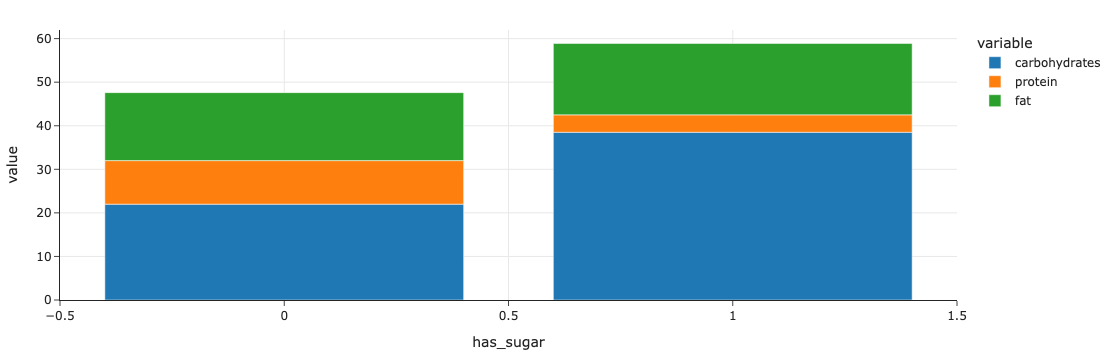

In [37]:
# determine weather or not the ingredients contain sugar
sug_df = (
        df.assign(has_sugar=
        df['ingredients']
                  .apply(lambda s: np.array(['sugar' in ing for ing in s]).sum() > 1)
                  .astype(int)
                )
        )
sug_df = (sug_df.groupby('has_sugar')
                .agg({
                        'calories': 'median',
                        'carbohydrates': 'median',
                        'protein': 'median',
                        'fat': 'median',
                        'sugar': 'median'
                }))
# display_df(sug_df)

# the follwing shows the buildup for recipes with and without sugar as one of the ingredients
sugar_calorie_make_up_fig = px.bar(sug_df, y=['carbohydrates', 'protein', 'fat'])

sugar_calorie_make_up_fig.show()

We can see how the presense of the ingredient sugar impacts the overall nutrition of the recipe. Having sugar as one of the ingredients, increases calories, far, and carbs while decreasing protein. 

$$\text{calories} = 9 \cdot \text{fat} + 4 \cdot \text{carbohydrates} + 4 \cdot \text{protein}$$
Where far, carbohydrates and protein is represented in grams.

In [38]:
# px.bar(sug_df, y='sugar').show()

The bar graph above shows that while recipes where one of the ingredients includes sugar tend to have a higher sugar quantity, it's possible for even those recipes without them to by sugary.

However, this begs some interesting questions...
1) What are some of the most influential ingredredients?
2) Can we predict their presense using the other features we have?

Let's see...

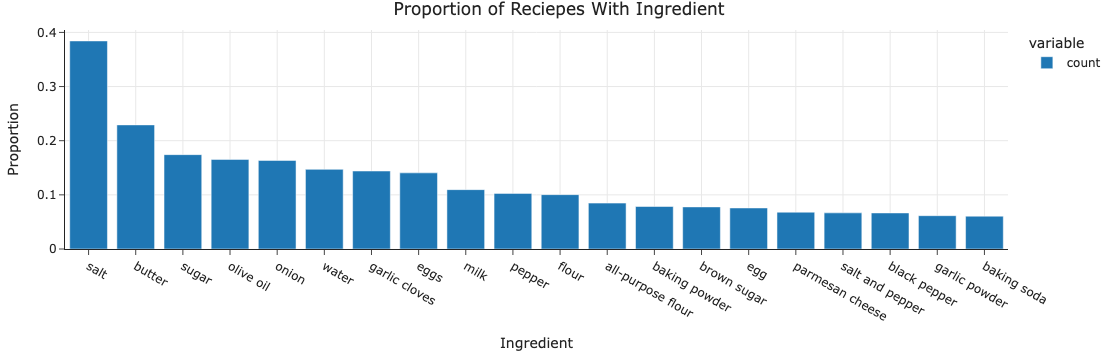

In [39]:
# creating a series of the most popular ingredients. The values are the proportion recipes which have them.
# this reflects any class imbalances
all_ingredients = np.concatenate(df['ingredients'].values)
popular_ingredient_counts = ((pd.Series(all_ingredients).value_counts()) / df.shape[0]).head(20)
impopular_ingredient_counts = pd.Series(all_ingredients).value_counts().tail(20)


# plotting the popular ingredients
(px
 .bar(popular_ingredient_counts, title='Proportion of Reciepes With Ingredient')
 .update_layout(xaxis_title = 'Ingredient', yaxis_title='Proportion')
)

Lot's of interesting ingredients to choose to predict. So which one? <br>
Well let's see which one has correlations with the Macros we saw earlier.

In [40]:
# creating plots on the macro medians vs ingredients
# note: plotting meadians due to the presence of severe outliers in the dataset 
def plt_macros_bar(df, ing):
    ing_df = (
        df
        .assign(has_ing= df['ingredients']
                .apply(lambda s: np.array([ing in ingredient for ingredient in s]).sum() >= 1)
                .astype(int))
        .groupby('has_ing')
        .agg({
                        'calories': 'median',
                        'carbohydrates': 'median',
                        'protein': 'median',
                        'fat': 'median',
                        'sugar': 'median'})
        )
    #display_df(ing_df)
    print(ing_df.to_markdown())
    
    return (
        px
        .bar(ing_df, y=['carbohydrates', 'protein', 'fat'], title=f'Recipe Macro Composisiton With and Without {ing.title()} Ingredient')
        .update_layout(xaxis_title=f'{ing}', yaxis_title=f'grams')
    )
# creating graphs for the following ingredients
# plt_macros_bar(df, 'salt').show()
# plt_macros_bar(df, 'water').show() # shows correlation not causation
plt_macros_bar(df, 'butter')
plt_macros_bar(df, 'eggs')

|   has_ing |   calories |   carbohydrates |   protein |   fat |   sugar |
|----------:|-----------:|----------------:|----------:|------:|--------:|
|         0 |     288.74 |            22   |      10   | 13.26 |    10   |
|         1 |     357.62 |            27.5 |       7.5 | 19.5  |    13.5 |
|   has_ing |   calories |   carbohydrates |   protein |   fat |   sugar |
|----------:|-----------:|----------------:|----------:|------:|--------:|
|         0 |     301.22 |            22   |       9   | 14.82 |    10.5 |
|         1 |     349.68 |            27.5 |       8.5 | 19.5  |    20.5 |


Similarly with the tags...

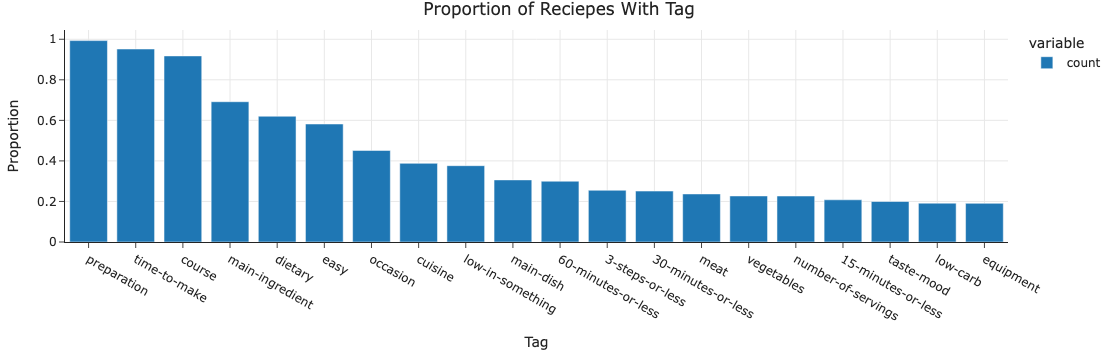

In [44]:
# creating a series of the most popular tags. The values are the proportion recipes which have them.
# this reflects any class imbalances
tags = (pd.Series(np.concatenate(df['tags'].values)).value_counts() / df.shape[0]).head(20) # proportion
# plotting the popular tags
(
    px
    .bar(tags, title='Proportion of Reciepes With Tag')
    .update_layout(xaxis_title = 'Tag', yaxis_title='Proportion')
)

In [45]:
# creating plots on the macro medians vs tags
# note: plotting meadians due to the presence of severe outliers in the dataset
def plt_macros_bar_tag(df, tag):
    tag_df = (
        df
        .assign(has_tag= df['tags']
                .apply(lambda s: np.array([tag in tags for tags in s]).sum() >= 1)
                .astype(int))
        .groupby('has_tag')
        .agg({
                        'calories': 'median',
                        'carbohydrates': 'median',
                        'protein': 'median',
                        'fat': 'median',
                        'sugar': 'median'})
        )
    #display_df(tag_df)
    print(tag_df.to_markdown(index=True))
    
    return (
        px
        .bar(tag_df, y=['carbohydrates', 'protein', 'fat'], title=f'Recipe Macro Composisiton With and Without {tag.title()} Tag')
        .update_layout(xaxis_title=f'{tag}', yaxis_title=f'grams')
    )

    
# creating graphs for the following tags
# plt_macros_bar_tag(df, 'dietary').show()
# plt_macros_bar_tag(df, 'cuisine').show()
# plt_macros_bar_tag(df, 'meat')
# plt_macros_bar_tag(df, 'vegetables')
# plt_macros_bar_tag(df, 'easy').show()
# plt_macros_bar_tag(df, 'occasion').show()
# plt_macros_bar_tag(df, 'low-in-something').show()

In [46]:
! ls

__pycache__    data           lec_utils.py   template.ipynb


## Step 3: Framing a Prediction Problem

These recipes seem to provide in depth nutritional explanations. However, what if this weren't the case. <br>
One may one want to know the nutritional information of their recipes, but not have adequete information (calories, protein, fat, arbohydrates, sodium, sugar, and saturated fat). In a realistic setting, we'd only know a few things: how  long the recipe takes, the # of ingredeints associated with the recipe, what the ingredeints are, and finally any tags you would associate with the recipe (the vibe of the recipe, if you will).

Hence, we will greate a **Regressor** for each of the aforementioned macros. <br>
Here's a few specifications on the regressor in addition to why we choose them. <br>
 - We will use a **Linear Regression** model for the regressor. Due to it's parametric nature, we will later be able to interprate the importance of certain features in the model. This can also provide key insights on certain ingredeints, tags, and trends based on the # of steps etc.
 - We will **Regularize** the model. In this way, we will be using **Lasso Regression**  for the model. The reason for Lasso is, again, intepretability. Lasso, standing for *Least Absolute Shrinkage and Selection* means that our trained model will only contain the parameters which actually impact our predictions.
 - Lastly, since we are predicting each macro, we will be creating a class whoose API consists of being able to select which Macro you'd like to see predicted.

## Step 4: Baseline Model

In [47]:
from sklearn import pipeline, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

In the baseline model, we will test this theory. It will be a more simple model. One aimed a solely predicting protein based on the presense of the meat tag, number of steps, number of ingredeints, and eggs. Later, we will add additional features and transform the numerical features.

In [48]:
class Baseline_model:
    def __init__(self, df):
        self.X_train, self.X_test, self.y_train, self.y_test = self.create_sample(df)
        self.model = None

    def create_sample(self, df):
        df = df.copy()

        # creating a meat (tag) column
        df['meat'] = (
            df['tags']
            .apply(lambda tags: np.array(['meat' in tag_word for tag_word in tags]).sum() >= 1)
            .astype(int))
        # creating an eggs (ingredeint) column
        df['eggs'] = (
            df['ingredients']
            .apply(lambda ings: np.array(['eggs' in ing_word for ing_word in ings]).sum() >= 1)
            .astype(int))

        return train_test_split(df[['meat', 'eggs', 'n_ingredients', 'n_steps']], df['protein'], test_size=0.2, random_state=98) 
    def create_pipeline(self):
        self.model = make_pipeline(LinearRegression())
        self.model.fit(self.X_train, self.y_train)
    def train(self):
        self.create_pipeline()

    def mses(self):
        train_mse = mean_squared_error(self.y_train, self.model.predict(self.X_train))
        test_mse = mean_squared_error(self.y_test, self.model.predict(self.X_test))
        print(f'Train MSE: {train_mse}.')
        print(f'Test MSE: {test_mse}.')
        

In [49]:
protein_model = Baseline_model(df)
protein_model.train()
protein_model.mses()

Train MSE: 441.73765804024004.
Test MSE: 604.5511145147225.


In [52]:
print(pd.Series({'Train MSE': 441.7376, 'Test MSE': 604.5511}).to_markdown())

|           |       0 |
|:----------|--------:|
| Train MSE | 441.738 |
| Test MSE  | 604.551 |


## Step 5: Final Model

With this baseline model, we can now work on an all encompassing model!

#### Feature Engineering <br>
Creating features with tags. <br> <br>
<b>Note</b>: no point in oneHotEncoding the tags later on as a while since there might be multiple of the most popular in the same recipe. Additionally, there's no point in oneHotEncoding each of the tags speratly as that will have the same effect as not oneHotEncoding in the first place.

In [53]:
# Creating the tag features
def create_tag_feature(df, tag):
    df[f'{tag}_tag'] = (df['tags']
        .apply(lambda tags: np.array([tag in tag_word for tag_word in tags]).sum() >= 1)
        .astype(int))
    
for tag in tags.index:
    create_tag_feature(df, tag) 

# Creating the ingredient features
def create_ing(df, ing):
    df[f'{ing}_ing'] = (df['ingredients']
        .apply(lambda ingredients: np.array([ing in ing_word for ing_word in ingredients]).sum() >= 1)
        .astype(int))

for y in popular_ingredient_counts.index:
    create_ing(df, y)

Maybe how certain tags and ingredients come into play together?

In [54]:
# group by method
# tag_and_ing_df = (
#     df.groupby(['dietary_tag', 'sugar_ing'])
#          .agg({
#                         'calories': 'median',
#                         'carbohydrates': 'median',
#                         'protein': 'median',
#                         'fat': 'median',
#                         'sugar': 'median'})
#         ).reset_index()
# using a pivot table
tag_and_ing_df = (
    df.pivot_table(
        index='meat_tag',
        columns='eggs_ing',
        values='protein',
        aggfunc='median'
    ))

# some_df
# some_pivot_df.plot(kind='bar', barmode='group', title='Protein in Recipes based on Meat and Eggs')

Building Class for the Model

So as we can see, while the accuracy may seem satisfactory, there's a huge class imbalance in the proportion of recipes which contain most of the intgredients. Due to this, the recall score and precision are very different despite trying to minimize the F1 score.

In [55]:
n_steps_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=1))
n_ingredients_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=1))
        
processing = make_column_transformer(
    (n_steps_pipeline, 'n_steps'),
    (n_ingredients_pipeline, 'n_ingredients'),
    remainder='passthrough')
make_pipeline(processing, Lasso())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=1))]),
                                                  'n_steps'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=1))]),
                                                  'n_ingredients')])),
                ('lasso', Lasso())])

In [64]:
class Macro_models:
    def __init__(self, df):
        # class contains a model for each of the macros
        self.X_train, self.X_test, _, _ = self.create_sample(df)
        self.macros=['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
        self.models={macro: None for macro in self.macros}
        
    def create_sample(self, df):
        # choosing the columns for the design matrix
        cols = np.concatenate((['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates', 'n_steps', 'n_ingredients'],
                            df.columns[pd.Series(df.columns).str.endswith('tag')==1],
                            df.columns[pd.Series(df.columns).str.endswith('ing')==1]))
        # since we will be inputting the train variable later, we choose an arbitrary column
        # setting the test size to 0.2
        return train_test_split(df[[col for col in cols]], df['sodium'], test_size=0.2, random_state=98)
        
        
    def create_regression_pipeline(self):
        # for numerical models: standared scaler following by polynomial features (changed in gridsearch)
        
        n_steps_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(include_bias=False, degree=1))
        n_ingredients_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(include_bias=False, degree=1))
        
        processing = make_column_transformer(
            (n_steps_pipeline, ['n_steps']),
            (n_ingredients_pipeline, ['n_ingredients']),
            remainder='passthrough')
        return make_pipeline(processing, Lasso())
        

    def create_macro_model(self, macro):
        # hyperparams to change: Lasso, polynomial features for numerical columns
        hyperparams = {
            'columntransformer__pipeline-1__polynomialfeatures__degree': np.arange(1, 4),
            'columntransformer__pipeline-2__polynomialfeatures__degree': np.arange(1, 4),
            'lasso__alpha': [2 ** n for n in range(-4, 4)]
        }
        # creating a gridsearch cv instance with 5 fold cross validation
        model = (
            GridSearchCV(
                self.create_regression_pipeline(),
                param_grid=hyperparams,
                cv=5,
                scoring='neg_mean_squared_error',
            ))
        model.fit(X=self.X_train.drop(columns=self.macros), y=self.X_train[macro])
        return model

    def train(self):
        # creating a model for each of the training macors
        for macro in self.macros:
            print(f"Training model for {macro} macro.")
            self.models[macro] = (self.create_macro_model(macro))
            print(f"MSE achieved: {self.calc_mse(macro)}")
            print("################################################################################")

    def macro_MSEs(self):
        # the mean squared error on the test set for each of the macros
        return pd.Series({macro: mean_squared_error(self.X_test[macro], self.models[macro].predict(self.X_test.drop(columns=self.macros))) for macro in self.macros})

    def calc_mse(self, macro):
        # the mean equared error of the macro model on the training set
        return mean_squared_error(self.X_train[macro], self.models[macro].predict(self.X_train.drop(columns=self.macros)))

    def predict_sample(self, N, macro):
        # generating N outputs using the model for the specified macro
        indecies = np.random.choice(np.arange(0, self.X_test.shape[0]), N, replace=False)
        test_predictions = self.models[macro].predict(self.X_test.drop(columns=self.macros).iloc[indecies,:])
        return pd.DataFrame({'Real': self.X_test.iloc[indecies][macro], 'Predicted': test_predictions}).reset_index()

In [65]:
macro_models = Macro_models(df)

macro_models.train()

Training model for calories macro.
MSE achieved: 357029.57302060275
################################################################################
Training model for fat macro.
MSE achieved: 1664.674142104705
################################################################################
Training model for sugar macro.
MSE achieved: 9458.614681279241
################################################################################
Training model for sodium macro.
MSE achieved: 7239572.360355441
################################################################################
Training model for protein macro.
MSE achieved: 405.10476559080274
################################################################################
Training model for saturated fat macro.
MSE achieved: 215.6923335785588
################################################################################
Training model for carbohydrates macro.
MSE achieved: 4367.965169987788
############################################

In [71]:
mses = macro_models.macro_MSEs()

print(mses.to_markdown())

|               |                0 |
|:--------------|-----------------:|
| calories      | 418557           |
| fat           |   2144.63        |
| sugar         |  13047.8         |
| sodium        |      1.47567e+07 |
| protein       |    566.39        |
| saturated fat |    204.198       |
| carbohydrates |   5490.71        |


Although these may look different, their difference is due to the different in their means.

In [67]:
means = df[macro_models.macros].mean()
(
    pd
    .concat([means, mses], axis=1)
    .drop('sodium', axis=0)
    .set_axis(['Means', 'Test Mses'], axis=1)
    .plot(kind='scatter', x='Means', y='Test Mses', trendline='ols')
)
# Note the real regression line is more so exponential with sodium in the picture

Hence, it's key to visualize their differences through samples.

In [72]:
# the best hyperparameters for each of the models?
hyperparams_df = pd.DataFrame({macro: {
    'N_Steps Poly Features': macro_models.models[macro].best_params_['columntransformer__pipeline-1__polynomialfeatures__degree'],
    'N_Ingredients Poly Features': macro_models.models[macro].best_params_['columntransformer__pipeline-2__polynomialfeatures__degree'],
    'Lassor regressor': macro_models.models[macro].best_params_['lasso__alpha']}
           for macro in macro_models.macros})
print(hyperparams_df.to_markdown())

|                             |   calories |    fat |   sugar |   sodium |   protein |   saturated fat |   carbohydrates |
|:----------------------------|-----------:|-------:|--------:|---------:|----------:|----------------:|----------------:|
| N_Steps Poly Features       |     2      | 2      |  2      |      3   |    1      |          2      |          2      |
| N_Ingredients Poly Features |     2      | 2      |  3      |      2   |    1      |          2      |          2      |
| Lassor regressor            |     0.0625 | 0.0625 |  0.0625 |      0.5 |    0.0625 |          0.0625 |          0.0625 |


Now, to see the params:

In [74]:
# The intercepts
pd.Series({macro: macro_models.models[macro].best_estimator_.named_steps['lasso'].intercept_ for macro in macro_models.macros})

calories         521.05
fat               25.20
sugar             35.25
sodium           756.30
protein           21.36
saturated fat      6.49
carbohydrates     41.28
dtype: float64

In [75]:
df_copy = df.copy()
# creating the same columns
cols = np.concatenate((['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates', 'n_steps', 'n_ingredients'],
                            df.columns[pd.Series(df.columns).str.endswith('tag')==1],
                            df.columns[pd.Series(df.columns).str.endswith('ing')==1]))
df_copy = df_copy[[col for col in cols]].drop(columns=macro_models.macros)
macro_params_series = {macro: None for macro in macro_models.macros}

# creating the model
for macro in macro_models.models:
    indecies = df_copy.columns
    # poly features from N_steps
    for i in range(2, int(hyperparams_df.loc['N_Steps Poly Features', macro]+1)):
        indecies = indecies.insert(i-1, f'N_Steps Deg {i}')
    # poly features from N_ingredients
    for i in range(2, int(hyperparams_df.loc['N_Ingredients Poly Features', macro]+1)):
        indecies = indecies.insert(i+int(hyperparams_df.loc['N_Steps Poly Features', macro]-1), f'N_Ingredients Deg {i}')
    # creating the series
    macro_params_series[macro] = pd.Series(macro_models.models[macro].best_estimator_.named_steps['lasso'].coef_,
              index=indecies)
    

all_coefficients = pd.DataFrame(macro_params_series)


# display_df(pd.DataFrame(macro_params_series).head())

print(f'The total number of irrelevent coefficients across the macros: {(all_coefficients == 0).sum().sum()}')
print(all_coefficients.loc['meat_tag', :].to_markdown())

The total number of irrelevent coefficients across the macros: 54


calories         115.55
fat                9.75
sugar             -1.04
sodium           251.08
protein           11.16
saturated fat      2.35
carbohydrates     -4.09
Name: meat_tag, dtype: float64

In [76]:
print(all_coefficients.loc['meat_tag', :].to_markdown())

|               |   meat_tag |
|:--------------|-----------:|
| calories      |  115.549   |
| fat           |    9.74835 |
| sugar         |   -1.04353 |
| sodium        |  251.082   |
| protein       |   11.1625  |
| saturated fat |    2.35439 |
| carbohydrates |   -4.08609 |


As can be expected, there's a positive correlation between the meat tag and protein grams.

Goes to show that many of the features were not used in many of the features. Hence, for future direcetion, each of the macros can (seperately) be further optimized by removing unnessessary features. This is a big benefit of the high interpretability of Lasso!

In [87]:
print(all_coefficients[(all_coefficients['protein'] > 1) | (all_coefficients['protein'] < -1)]['protein'].to_markdown())

|                        |   protein |
|:-----------------------|----------:|
| 15-minutes-or-less_tag |  -3.74627 |
| 30-minutes-or-less_tag |  -2.27869 |
| 60-minutes-or-less_tag |  -2.51325 |
| baking powder_ing      |  -1.00415 |
| baking soda_ing        |  -1.69974 |
| course_tag             |  -5.9061  |
| low-carb_tag           |   4.09764 |
| main-dish_tag          |  10.6352  |
| meat_tag               |  11.1625  |
| n_ingredients          |   1.61722 |
| n_steps                |   1.09601 |
| sugar_ing              |  -2.62982 |
| time-to-make_tag       |  -2.06129 |
| vegetables_tag         |  -5.13664 |


In [78]:
macro_models.predict_sample(5, 'calories')

,index,Real,Predicted
0,197191,381.36,328.32
1,91995,362.42,926.84
2,21565,917.60,650.71
3,139464,181.04,341.16
4,103906,152.18,337.72
